# DATA PROCESSING AND CLEANUP

In [ ]:
pwd

In [ ]:
ls

In [ ]:
import os,tarfile

In [ ]:
# change current working directory to OULU
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')

In [ ]:
# list all files in OULU


In [ ]:
# EXTRACT .tar FILES FOR TRAINING DATA
train_files = tarfile.open('replayattack-train.tar.gz')
train_files.extractall('train_files') # specify which folder to extract to
train_files.close()

In [ ]:
# EXTRACT .tar FILES FOR TESTING DATA
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')
test_files = tarfile.open('replayattack-test.tar.gz')
os.chdir('/home/pineapple45/ANMOL/BTP/pixel-wise-supervision/replayattack')
test_files.extractall('test_files') # specify which folder to extract to
test_files.close()

In [ ]:
# EXTRACT .tar FILES FOR ENROLLMENT DATA
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')
enrollment_files = tarfile.open('replayattack-enroll.tar.gz')
os.chdir('/home/pineapple45/ANMOL/BTP/pixel-wise-supervision/replayattack')
enrollment_files.extractall('enrollment_files') # specify which folder to extract to
enrollment_files.close()

In [ ]:
# EXTRACT .tar FILES FOR DEVLOPEMENT DATA
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')
dev_files = tarfile.open('replayattack-devel.tar.gz')
os.chdir('/home/pineapple45/ANMOL/BTP/pixel-wise-supervision/replayattack')
dev_files.extractall('dev_files') # specify which folder to extract to
dev_files.close()


In [ ]:
# EXTRACT .tar FILES FOR FACE LOCATIONS DATA
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')
face_loc_files = tarfile.open('replayattack-face-locations-v2.tar.gz')
os.chdir('/home/pineapple45/ANMOL/BTP/pixel-wise-supervision/replayattack')
face_loc_files.extractall('face_loc_files') # specify which folder to extract to
face_loc_files.close()


In [ ]:
# EXTRACT .tar FILES FOR PROTOCOLS DATA
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')
protocols_files = tarfile.open('protocols-v3.tar.gz')
os.chdir('/home/pineapple45/ANMOL/BTP/pixel-wise-supervision/replayattack')
protocols_files.extractall('protocols_files') # specify which folder to extract to
protocols_files.close()


In [ ]:
# EXTRACT .tar FILES FOR COMPETETIONS ICB 2013 TESTSET DATA
os.chdir('/media/pineapple45/Elements/anmol/btp/replayattack')
icb_test_files = tarfile.open('competition_icb2013_testset.tar.gz')
os.chdir('/home/pineapple45/ANMOL/BTP/pixel-wise-supervision/replayattack')
icb_test_files.extractall('icb_test_files') # specify which folder to extract to
icb_test_files.close()


### EXTRACTING FRAMES FROM INPUT VIDEO

In [ ]:
import cv2
import numpy as np

In [ ]:
# DEFINING PARAMETERS FOR VIDEO CLASSIFICATION
IMG_SIZE=256
CHANNELS=3

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
import cv2  
  
# Load the cascade  
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  
  
# To capture video from existing video.   
cap = cv2.VideoCapture('test.mov')  
  
while True:  
    # Read the frame  
    _, img = cap.read()  
  
    # Convert to grayscale  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
  
    # Detect the faces  
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)  
  
    # Draw the rectangle around each face  
    for (x, y, w, h) in faces:  
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)  
  
    # Display  
    cv2.imshow('Video', img)  
  
    # Stop if escape key is pressed  
    k = cv2.waitKey(30) & 0xff  
    if k==27:  
        break  
          
# Release the VideoCapture object  
cap.release()  

# ACTUAL COMPUTATION

In [3]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
%cd '/content/drive/MyDrive/BTP/replay-attack-processed'

/content/drive/MyDrive/BTP/replay-attack-processed


In [78]:
import numpy as np
import zipfile, os, cv2, random
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model,Model
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
import glob
from pathlib import Path
from io import BytesIO
from google.colab.patches import cv2_imshow
matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# DataLoader

In [6]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
# IMG_SHAPE = (256, 256, 3)
archive = zipfile.ZipFile('/content/drive/MyDrive/BTP/replay-attack-processed/train.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.jpg' in k]
print('Train: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

archive = zipfile.ZipFile('/content/drive/MyDrive/BTP/replay-attack-processed/val.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.jpg' in k]
print('Val: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

archive = zipfile.ZipFile('/content/drive/MyDrive/BTP/replay-attack-processed/test.zip', 'r')
image_paths = [k for k in list(archive.namelist()) if '.jpg' in k]
print('Test: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

Train: Total = 91705 , Attack = 69215 , Real = 22490
Val: Total = 90952 , Attack = 68467 , Real = 22485
Test: Total = 121028 , Attack = 91799 , Real = 29229


In [ ]:
# RUN THIS CODE CELL LOCALLY
# IMG_SHAPE = (256, 256, 3)

image_paths = [k for k in glob.iglob('./data/train' + '/**/*.jpg', recursive=True)]
print('Train: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

image_paths = [k for k in glob.iglob('./data/test' + '/**/*.jpg', recursive=True)]
print('Test: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

image_paths = [k for k in glob.iglob('./data/val' + '/**/*.jpg', recursive=True)]
print('Validation: Total =',len(image_paths), ', Attack =',len([path for path in image_paths if 'attack' in path]), ', Real =', len([path for path in image_paths if 'real' in path]))

Train: Total = 91705 , Attack = 69215 , Real = 22490
Test: Total = 121028 , Attack = 91799 , Real = 29229
Validation: Total = 90952 , Attack = 68467 , Real = 22485


In [7]:
def new_py_function(func, inp, Tout, name=None):
  def wrapped_func(*flat_inp):
    reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,expand_composites=True)
    out = func(*reconstructed_inp)
    return tf.nest.flatten(out, expand_composites=True)
  flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
  flat_out = tf.py_function(
      func=wrapped_func, 
      inp=tf.nest.flatten(inp, expand_composites=True),
      Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
      name=name)
  spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, 
                                   expand_composites=True)
  out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
  return out

def _dtype_to_tensor_spec(v):
  return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
  return v.dtype if isinstance(v, tf.TensorSpec) else v

In [ ]:
# RUN THIS CODE CELL LOCALLY
class DataLoader:
  def __init__(self, dataset_path, batch_size=4, image_size=(256, 256), shuffle=True):
    self.images_paths = [k for k in glob.iglob(dataset_path + '/**/*.jpg', recursive=True)]
    random.shuffle(self.images_paths)
    self.length = len(self.images_paths)
    self.dim = image_size
    dataset = tf.data.Dataset.from_tensor_slices(self.images_paths).map(
            self.pad_map_fn, num_parallel_calls=3
          )
    if shuffle:
#       dataset = dataset.shuffle(buffer_size=100000, reshuffle_each_iteration=True)
      dataset = dataset.shuffle(buffer_size=5000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=3)
    # dataset = dataset.repeat()
    self.dataset = dataset.apply(tf.data.experimental.ignore_errors())  
                  
  def __len__(self):
        return self.length

  def load_tf_image(self, image_path):
    image_path = image_path.numpy().decode("utf-8")
#     img_data = self.archive.read(image_path.strip())
#     img_data = Image.open(image_path)
#     img_data = img_data.tobytes("xbm", "rgb")
#     image = np.frombuffer(img_data, np.uint8)
    image = cv2.imread(f"{image_path}")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, self.dim)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.per_image_standardization(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # label - attack = 0, real = 1
    if 'attack' in image_path:
      label =  tf.constant([0])
      label_8 = tf.zeros_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.zeros_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.zeros_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.zeros_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
    if 'real' in image_path:
      label = tf.constant([1])
      label_8 = tf.ones_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.ones_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.ones_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.ones_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))

    return {'image': image, 'label': label, 'label_8': label_8, 'label_4': label_4, 'label_2': label_2, 'label_1': label_1}

  def pad_map_fn(self, img_path):
    return new_py_function(self.load_tf_image, inp=[img_path], Tout=({"image": tf.float32, "label": tf.int32, 'label_8': tf.float32, 'label_4': tf.float32, 'label_2': tf.float32, 'label_1': tf.float32}))

In [60]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
class DataLoader:
  def __init__(self, dataset_path, batch_size=4, image_size=(256, 256), shuffle=True):
    self.archive = zipfile.ZipFile(dataset_path, 'r')
    self.images_paths = [k for k in list(self.archive.namelist()) if '.jpg' in k]
    random.shuffle(self.images_paths)
    self.length = len(self.images_paths)
    self.dim = image_size
    dataset = tf.data.Dataset.from_tensor_slices(self.images_paths).map(
            self.pad_map_fn, num_parallel_calls=3
          )
    if shuffle:
      dtaset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=3)
    # dataset = dataset.repeat()
    self.dataset = dataset.apply(tf.data.experimental.ignore_errors())  
                  
  def __len__(self):
        return self.length

  def load_tf_image(self, image_path):
    image_path = image_path.numpy().decode("utf-8")
    img_data = self.archive.read(image_path.strip())
    image = np.frombuffer(img_data, np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    original_image = image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, self.dim)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.per_image_standardization(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # label - spoof = 0, real = 1
    if 'attack' in image_path:
      label =  tf.constant([0])
      label_8 = tf.zeros_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.zeros_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.zeros_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.zeros_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
    if 'real' in image_path:
      label = tf.constant([1])
      label_8 = tf.ones_like(tf.random.uniform(shape=(8,8,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_4 = tf.ones_like(tf.random.uniform(shape=(4,4,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_2 = tf.ones_like(tf.random.uniform(shape=(2,2,1), minval=0, maxval=1, dtype=tf.dtypes.float32))
      label_1 = tf.ones_like(tf.random.uniform(shape=(1,1,1), minval=0, maxval=1, dtype=tf.dtypes.float32))

    return {'original_image': original_image, 'image': image, 'label': label, 'label_8': label_8, 'label_4': label_4, 'label_2': label_2, 'label_1': label_1}

  def pad_map_fn(self, img_path):
    return new_py_function(self.load_tf_image, inp=[img_path], Tout=({"original_image":tf.float32, "image": tf.float32, "label": tf.int32, 'label_8': tf.float32, 'label_4': tf.float32, 'label_2': tf.float32, 'label_1': tf.float32}))

In [ ]:
# RUN THIS CODE CELL LOCALLY
loader = DataLoader('./data/train', batch_size=32,shuffle=False)

In [61]:
# RUN THIS CODE CELL IN GOOGLE-COLLAB
loader = DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/train.zip', batch_size=32,shuffle=False)

In [ ]:
# loader.load_tf_image('./data/train/real/frame_15.jpg')['label_1']

In [ ]:
# loader.pad_map_fn('./data/train/real/frame_15.jpg')

In [65]:
dataset = loader.dataset.take(2)
# list(dataset.as_numpy_iterator())
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  print(a['image'].shape, a['label'].shape, a['label_8'].shape, a['label_4'].shape, a['label_2'].shape, a['label_1'].shape)


(32, 256, 256, 3) (32, 1) (32, 8, 8, 1) (32, 4, 4, 1) (32, 2, 2, 1) (32, 1, 1, 1)
(32, 256, 256, 3) (32, 1) (32, 8, 8, 1) (32, 4, 4, 1) (32, 2, 2, 1) (32, 1, 1, 1)


In [9]:
IMG_SHAPE = (256, 256, 3)

In [10]:
class RevisitResNet50(tf.keras.Model):
  def __init__(self, name="revisit_resnet50", **kwargs):
    super(RevisitResNet50, self).__init__()
    self.backbone = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    # avg. pooling
    self.avgpool_8 = layers.AveragePooling2D(pool_size=(1,1), strides=1, padding='valid', data_format=None)
    self.avgpool_4= layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='valid', data_format=None)
    self.avgpool_2= layers.AveragePooling2D(pool_size=(4,4), strides=4, padding='valid', data_format=None)
    self.avgpool_1= layers.AveragePooling2D(pool_size=(8,8), strides=8, padding='valid', data_format=None)
    # 1x1 conv
    self.theta_8 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_4 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_2 = layers.Conv2D(1, (1,1), activation='sigmoid')
    self.theta_1 = layers.Conv2D(1, (1,1), activation='sigmoid')
    # dense layer
    self.fc = layers.Dense(1, activation='sigmoid')
    # loss
    self.loss_object = tf.keras.losses.BinaryCrossentropy()

  def call(self, input_img, label_8, label_4, label_2, label_1):
    F = self.backbone(input_img)
    # M8
    x = self.avgpool_8(F)
    M8 = self.theta_8(x)
    # M4
    x = self.avgpool_4(F)
    M4 = self.theta_4(x)
    # M2
    x = self.avgpool_2(F)
    M2 = self.theta_2(x)
    # M1
    x = self.avgpool_1(F)
    M1 = self.theta_1(x)
    # concatenate and predict
    x = layers.Concatenate(axis=1)([layers.Flatten()(M8), layers.Flatten()(M4), layers.Flatten()(M2), layers.Flatten()(M1)])
    y_pred = self.fc(x)
    # pyramid loss
    pyramid_loss = tf.reduce_mean([self.loss_object(label_8, M8), self.loss_object(label_4, M4), self.loss_object(label_2, M2), self.loss_object(label_1, M1)])
    self.add_loss(pyramid_loss)

    return y_pred
  
  def build_model(self):
    x = layers.Input(shape=IMG_SHAPE)
    label_8 = layers.Input(shape=(8,8,1), dtype="float32")
    label_4 = layers.Input(shape=(4,4,1), dtype="float32")
    label_2 = layers.Input(shape=(2,2,1), dtype="float32")
    label_1 = layers.Input(shape=(1,1,1), dtype="float32")
    return Model(inputs=[x, label_8, label_4, label_2, label_1], outputs=self.call(x, label_8, label_4, label_2, label_1))


revisit_model = RevisitResNet50()
test_model = revisit_model.build_model()
test_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['input_2[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 8, 8, 2048)  0           ['resnet50[0][0]']               
 ing2D)                                                                                           
                             

In [11]:
def calculate_apcer(y_true, y_pred):
    true_spoof = 0  #### Spoof being 1
    false_real = 0  #### real being 0
    for i in range(len(y_true)):
        target = y_true[i]
        pred = y_pred[i]
        if target:
            true_spoof += 1
            if not pred:
                false_real += 1
    return false_real / true_spoof if true_spoof else 0

In [12]:
def calculate_bpcer(y_true, y_pred):
    true_real = 0  #### Spoof being 1
    false_spoof = 0  #### real being 0
    for i in range(len(y_true)):   
        target = y_true[i]
        pred = y_pred[i]
        if not target:
            true_real += 1
            if pred:
                false_spoof += 1
    return false_spoof / true_real if true_real else 0

In [74]:
train_loader = DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/train.zip', batch_size=64, shuffle=True)
val_loader =  DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/val.zip', batch_size=64, shuffle=False)
test_loader = DataLoader('/content/drive/MyDrive/BTP/replay-attack-processed/test.zip', batch_size=64, shuffle=False)

In [14]:
# len(train_loader.dataset)
print(len(train_loader))
print(len(val_loader))

91705
90952


In [15]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=5e-5)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=5e-5)
bce_loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_metric = tf.keras.metrics.Mean()

In [16]:
revisit_model.load_weights('/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50/cp.ckpt')

In [ ]:
epochs = 80
start = datetime.now() 
for epoch in range(0,epochs+1): 
  print("Start of epoch %d" % (epoch,))

  # Iterate over the batches of the dataset
  for step, batch_train in enumerate(train_loader.dataset):
    # print(batch_train['image'].shape, batch_train['label'].shape, batch_train['label_8'].shape, batch_train['label_4'].shape, batch_train['label_2'].shape, batch_train['label_1'].shape)
    
    with tf.GradientTape() as tape:
        pred = revisit_model(batch_train['image'], batch_train['label_8'], batch_train['label_4'], batch_train['label_2'], batch_train['label_1'], training=True)
        # compute bcse loss
        loss = bce_loss_fn(batch_train['label'], pred)
        loss += sum(revisit_model.losses)  # add pyramid loss

    grads = tape.gradient(loss, revisit_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, revisit_model.trainable_weights))

    loss_metric(loss)

    if (step+1) % 750 == 0:
      diff_time = datetime.now()-start
      days, seconds = diff_time.days, diff_time.seconds
      hours = days * 24 + seconds // 3600
      minutes = (seconds % 3600) // 60
      seconds = seconds % 60
      print("step %d: mean loss = %.6f, time = %d:%d:%d" % (step+1, loss_metric.result(), hours, minutes, seconds))
      revisit_model.save_weights('/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50/cp.ckpt')

revisit_model.save_weights('/content/drive/MyDrive/BTP/replay-attack-processed/checkpoints/resnet50/cp.ckpt')

Start of epoch 0
step 750: mean loss = 0.246263, time = 0:12:44
Start of epoch 1
step 750: mean loss = 0.132357, time = 0:35:26
Start of epoch 2
step 750: mean loss = 0.099830, time = 0:58:21
Start of epoch 3
step 750: mean loss = 0.083328, time = 1:20:32
Start of epoch 4
step 750: mean loss = 0.072835, time = 1:43:3
Start of epoch 5
step 750: mean loss = 0.065554, time = 2:5:48
Start of epoch 6
step 750: mean loss = 0.060130, time = 2:28:6
Start of epoch 7
step 750: mean loss = 0.055899, time = 2:50:24
Start of epoch 8
step 750: mean loss = 0.052477, time = 3:12:42
Start of epoch 9
step 750: mean loss = 0.049640, time = 3:35:5
Start of epoch 10
step 750: mean loss = 0.047250, time = 3:57:21
Start of epoch 11
step 750: mean loss = 0.045190, time = 4:19:37
Start of epoch 12
step 750: mean loss = 0.043380, time = 4:42:8
Start of epoch 13
step 750: mean loss = 0.041795, time = 5:4:31
Start of epoch 14
step 750: mean loss = 0.040386, time = 5:26:55
Start of epoch 15
step 750: mean loss = 0

(64, 256, 256, 3) (64, 256, 256, 3) (64, 1) (64, 8, 8, 1) (64, 4, 4, 1) (64, 2, 2, 1) (64, 1, 1, 1)


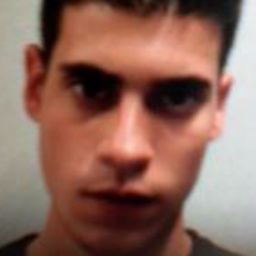

In [72]:
dataset = val_loader.dataset.take(1)
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  print(a['original_image'].shape, a['image'].shape, a['label'].shape, a['label_8'].shape, a['label_4'].shape, a['label_2'].shape, a['label_1'].shape)
  # print(a['image'])
  cv2_imshow(a['original_image'][0])

In [73]:
ths = 0.12
for step, batch in enumerate(val_loader.dataset):
  pred = revisit_model(batch['image'], batch['label_8'], batch['label_4'], batch['label_2'], batch['label_1'], training=False)
  pred_ = [1 if i>ths else 0 for i in pred.numpy().reshape(batch['label'].shape[0])]
  labels = [int(i) for i in batch['label'].numpy().reshape(batch['label'].shape[0])]
  print(pred.numpy().reshape(batch['label'].shape[0]))
  print(pred_)
  print(labels)
  print(calculate_apcer(labels, pred_))
  break

[0.01069435 0.00835467 0.01171602 0.00441297 0.99878603 0.01107987
 0.00583074 0.01143271 0.9988458  0.01483636 0.00939777 0.01475551
 0.04639601 0.00956023 0.99902904 0.00532402 0.99910897 0.00711573
 0.99761105 0.01459572 0.9986986  0.01046652 0.04611729 0.00678993
 0.99885356 0.00934451 0.9987858  0.00505971 0.9988727  0.993808
 0.00786722 0.0063717  0.00606979 0.00910079 0.01158722 0.89618474
 0.00579495 0.00712733 0.99876654 0.00490505 0.00925261 0.01764331
 0.00861573 0.00890824 0.00791202 0.9983816  0.00491687 0.01159847
 0.96515524 0.00908745 0.00943418 0.00721077 0.99878436 0.00750866
 0.0112094  0.00472167 0.99851364 0.9987888  0.00696817 0.01018306
 0.01728564 0.01062738 0.0097823  0.01188201]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,

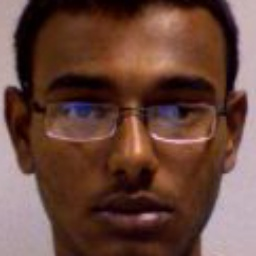

In [77]:
# testing on a single test image
ths = 0.12

dataset = test_loader.dataset.take(1)
# list(dataset.as_numpy_iterator())
a = list(dataset.as_numpy_iterator())
for a in list(dataset.as_numpy_iterator()):
  # print(a['original_image'])
  cv2_imshow(a['original_image'][0])
# revisit_model.predict()